# Вычисление параметров для молекулярной механики

In [1]:
import psi4
import numpy as np
psi4.core.set_output_file('output.dat')
from IPython.display import display,Image

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from math import pi
from math import e

В рамках молекулярной механики атомы и связи между ними рассматриватся с классической точки зрения, а решение уравнения Шрёдингера заменяется на решение классических уравнений с какими-то подобранными параметрами, которые вместе называются силовым полем. В этом практикуме мы будем исходя из квантовомеханических расчётов подбирать параметры для аппроксимации зависимости энергии этана от длины ковалентной связи, валентных углов и торсионного угла.

Запишем строение этана в виде z-матрицы:

In [3]:
g = '''
C
C 1 1.52986
H 1 1.08439 2 111.200
H 1 1.08439 2 111.200 3 120
H 1 1.08439 2 111.200 3 -120
H 2 1.08439 1 111.200 3 180
H 2 1.08439 1 111.200 6 120
H 2 1.08439 1 111.200 6 -120
'''

Проверим, что наша запись корректно отражает заторможенную конформацию молекулы. Для этого перепишем наше представление в формат xyz и визуализируем с помощью паймола.

In [4]:
m = psi4.geometry(g)
file = open('ethane.xyz','w')
s = m.save_string_xyz_file()
file.write(s)
file.close()

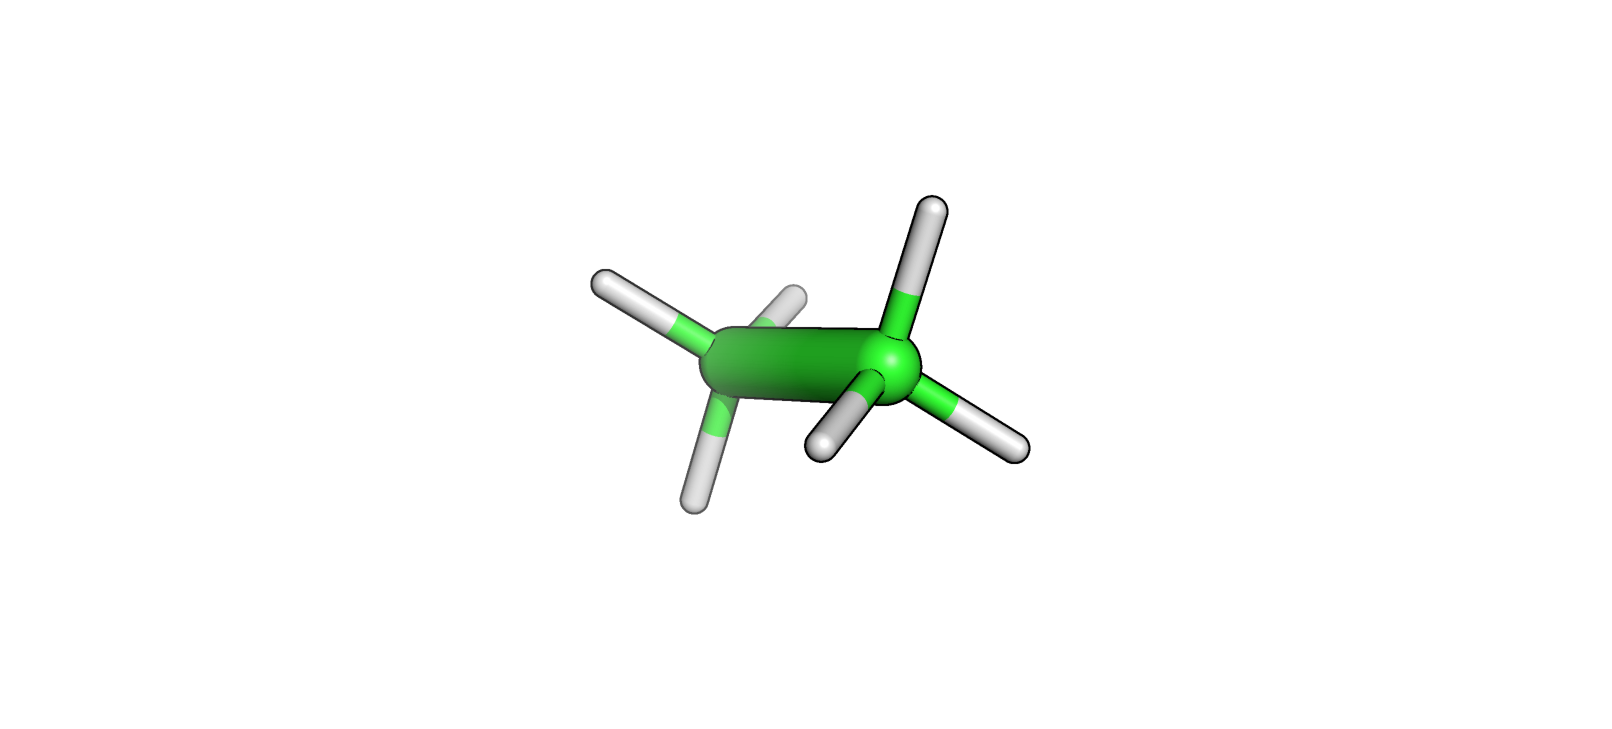

In [17]:
display(Image('./ethane.png',width=500))

Запишем функцию для расчёта энергии молекулы с заданной геометрией с помощью квантовой химии и посчитаем энергию нашей структуры

In [5]:
def run_psi4(g):
    m = psi4.geometry(g)
    psi4.set_options({"maxiter": 200, "fail_on_maxiter" :  True})
    x = psi4.energy('scf/cc-pvtz', molecule = m, )

    return x

In [20]:
run_psi4(g)

-79.26001266653255

## Зависимость энергии от длины ковалентной связи CC

Будем менять длину связи C-C от 1.3 ангстрем до 1.68 с шагом 0.02 ангстрема и на каждом шаге считать энергию

In [22]:
g_f = '''
C
C 1 {0}
H 1 1.08439 2 111.200
H 1 1.08439 2 111.200 3 120
H 1 1.08439 2 111.200 3 -120
H 2 1.08439 1 111.200 3 180
H 2 1.08439 1 111.200 6 120
H 2 1.08439 1 111.200 6 -120
'''

In [23]:
dist = 1.3
dists = []
energies_d = []
for i in range(20):
    g = g_f.format(dist)
    energy = run_psi4(g)
    print('dist: '+str(dist)+'    energy: '+str(energy))
    dist = round(dist + 0.02,2)
    dists.append(dist)
    energies_d.append(energy)

dist: 1.3    energy: -79.21801576654612
dist: 1.32    energy: -79.22644049207102
dist: 1.34    energy: -79.23367565650369
dist: 1.36    energy: -79.23982689781072
dist: 1.38    energy: -79.24499065822164
dist: 1.4    energy: -79.24925504726096
dist: 1.42    energy: -79.25270061396391
dist: 1.44    energy: -79.25540103773741
dist: 1.46    energy: -79.25742374735763
dist: 1.48    energy: -79.25883047627197
dist: 1.5    energy: -79.2596777611329
dist: 1.52    energy: -79.26001739044742
dist: 1.54    energy: -79.25989681025159
dist: 1.56    energy: -79.25935949015516
dist: 1.58    energy: -79.25844525649651
dist: 1.6    energy: -79.25719059439069
dist: 1.62    energy: -79.25562892435684
dist: 1.64    energy: -79.25379085424464
dist: 1.66    energy: -79.25170441069218
dist: 1.68    energy: -79.24939525102377


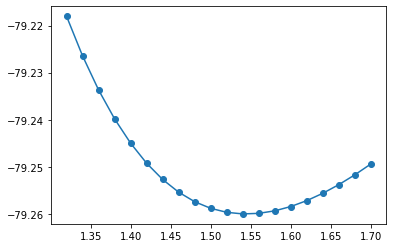

In [25]:
dists = np.array(dists)
energies_d = np.array(energies_d)
plt.plot(dists,energies_d,marker='o')

Мы видим, что зависимость энергии от длины связи C-C имеет вид близкий к параболе, поэтому попытаемся подобрать параметры параболы, которой можно было бы аппроксимировать эту зависимость. По сути мы собираемся использовать гармоническое приближение.

In [28]:
# fake x array , replace with real one
x_o=dists
# fake y array, replace with energies
y_o=energies_d

#function is  f(x)=k(b-x)^2 + a
fitfunc = lambda p, x: p[0]*pow(p[1]-x,2) + p[2] # Target function
errfunc = lambda p, x, y: fitfunc(p, x) - y # Error function

p0 = [1,1, -79] # Initial guess for the parameters
p1, success = optimize.leastsq(errfunc, p0[:], args=(x_o, y_o))
print("Optimized params:", p1)

Optimized params: [  0.70680797   1.55860041 -79.26115338]


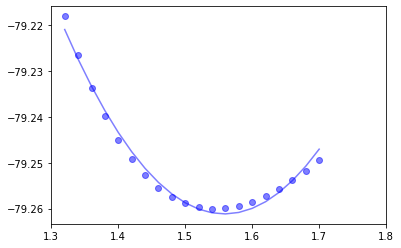

In [27]:
#Plot it
plt.plot(x_o, y_o, "bo", x_o,fitfunc(p1,x_o),"b-",alpha=0.5)
plt.xlim(1.3,1.8)
plt.show()

По картинке мы видим, что приближение с помощью параболы является довольно точным, однако даже при небольших изменениях длины связи наблюдается отклонения от параболической формы. Тем не менее в итоге мы получаем три параметра: первый отвечает за скорость роста энергии при удалении от оптимального расстояния, второй указывает на минимум энергии (что удивительным образом совпадает с исходной длиной связи), третий показывает минимальное значение энергии

## Зависимость энергии от величины валентного угла CCH

Проделаем всё то же самое, но теперь будем изменять величину валентного угла CCH от 109.2 до 113.2 с шагом 0.2 градуса.

In [29]:
g_f = '''
C
C 1 1.52986
H 1 1.08439 2 {0}
H 1 1.08439 2 {0} 3 120
H 1 1.08439 2 {0} 3 -120
H 2 1.08439 1 {0} 3 180
H 2 1.08439 1 {0} 6 120
H 2 1.08439 1 {0} 6 -120
'''

In [30]:
valence_angle = 109.2
valence_angles = []
energies_a = []
while valence_angle <= 113.2:
    g = g_f.format(valence_angle)
    energy = run_psi4(g)
    print('valence_angle: '+str(valence_angle)+'    energy: '+str(energy))
    valence_angle = round(valence_angle + 0.2,2)
    valence_angles.append(valence_angle)
    energies_a.append(energy)

valence_angle: 109.2    energy: -79.25885961108017
valence_angle: 109.4    energy: -79.25908365095631
valence_angle: 109.6    energy: -79.25928367901126
valence_angle: 109.8    energy: -79.25945963905406
valence_angle: 110.0    energy: -79.25961147450528
valence_angle: 110.2    energy: -79.25973912857438
valence_angle: 110.4    energy: -79.25984254409306
valence_angle: 110.6    energy: -79.2599216635706
valence_angle: 110.8    energy: -79.25997642926072
valence_angle: 111.0    energy: -79.26000678303926
valence_angle: 111.2    energy: -79.26001266653255
valence_angle: 111.4    energy: -79.25999402111714
valence_angle: 111.6    energy: -79.25995078763044
valence_angle: 111.8    energy: -79.25988290693145
valence_angle: 112.0    energy: -79.25979031936764
valence_angle: 112.2    energy: -79.2596729650375
valence_angle: 112.4    energy: -79.25953078363327
valence_angle: 112.6    energy: -79.25936371478414
valence_angle: 112.8    energy: -79.2591716975158
valence_angle: 113.0    energy: -7

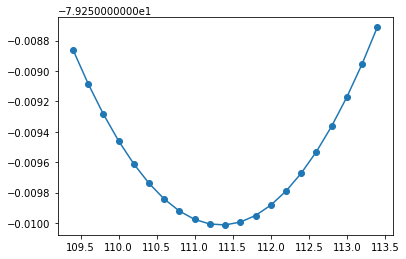

In [32]:
valence_angles = np.array(valence_angles)
energies_a = np.array(energies_a)
plt.plot(valence_angles,energies_a,marker='o')

In [33]:
# fake x array , replace with real one
x_o=valence_angles
# fake y array, replace with energies
y_o=energies_a

#function is  f(x)=k(b-x)^2 + a
fitfunc = lambda p, x: p[0]*pow(p[1]-x,2) + p[2] # Target function
errfunc = lambda p, x, y: fitfunc(p, x) - y # Error function

p0 = [1,1, -79] # Initial guess for the parameters
p1, success = optimize.leastsq(errfunc, p0[:], args=(x_o, y_o))
print("Optimized params:", p1)

Optimized params: [ 3.06641830e-04  1.11342796e+02 -7.92600137e+01]


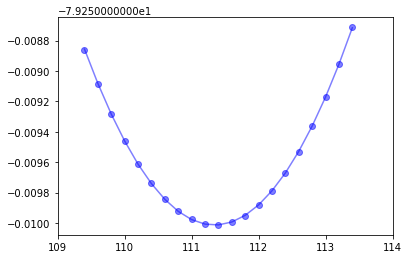

In [34]:
#Plot it
plt.plot(x_o, y_o, "bo", x_o,fitfunc(p1,x_o),"b-",alpha=0.5)
plt.xlim(109,114)
plt.show()

Итого мы видим, что зависимость энергии от величины валентного угла также имеет параболическую форму и аппроксимируется с помощью того же набора параметров.

## Зависимость энергии от величины торсионного угла

В молекуле этана всего лишь один торсионный угол, поворот вокруг которого соответствует переходам между заслонёнными и заторможенными конформациями. Будем изменять его от -180 до 180 градусов с шагом 12.

torsion_angle: -180    energy: -79.26001266653304
torsion_angle: -168    energy: -79.25954606534684
torsion_angle: -156    energy: -79.25831799033347
torsion_angle: -144    energy: -79.25678696770248
torsion_angle: -132    energy: -79.25553784346805
torsion_angle: -120    energy: -79.25505826175069
torsion_angle: -108    energy: -79.25553784346643
torsion_angle: -96    energy: -79.2567869676861
torsion_angle: -84    energy: -79.25831799032912
torsion_angle: -72    energy: -79.25954606533479
torsion_angle: -60    energy: -79.26001266654546
torsion_angle: -48    energy: -79.25954606534556
torsion_angle: -36    energy: -79.25831799033543
torsion_angle: -24    energy: -79.25678696767737
torsion_angle: -12    energy: -79.25553784345232
torsion_angle: 0    energy: -79.25505826173027
torsion_angle: 12    energy: -79.25553784345843
torsion_angle: 24    energy: -79.25678696769128
torsion_angle: 36    energy: -79.25831799035403
torsion_angle: 48    energy: -79.25954606532923
torsion_angle: 60   

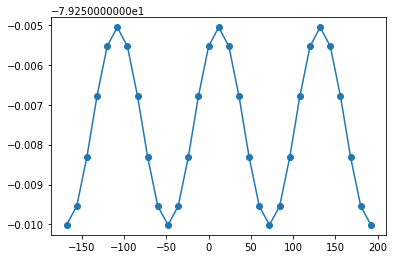

In [4]:
g_f = '''
C
C 1 1.52986
H 1 1.08439 2 111.200
H 1 1.08439 2 111.200 3 120
H 1 1.08439 2 111.200 3 -120
H 2 1.08439 1 111.200 3 {}
H 2 1.08439 1 111.200 6 120
H 2 1.08439 1 111.200 6 -120
'''

torsion_angle = -180
torsion_angles = []
energies_t = []
while torsion_angle <= 180:
    g = g_f.format(torsion_angle)
    energy = run_psi4(g)
    print('torsion_angle: '+str(torsion_angle)+'    energy: '+str(energy))
    torsion_angle = round(torsion_angle + 12,2)
    torsion_angles.append(torsion_angle)
    energies_t.append(energy)
    
torsion_angles = np.array(torsion_angles)
energies_t = np.array(energies_t)
plt.plot(torsion_angles,energies_t,marker='o')

Мы видим, что энергия при изменении торсионного угла изменяется периодически, причём за полный оборот угла претерпевает три периода колебаний, что связа с тем, что в молекуле этана у каждого атома углерода есть по три атома водорода. Аппроксимировать таку. зависимость мы будем с помощью косинуса, причём теперь параметра будет четыре: амплитуда изменений энергии, угловая частота (которая умножается на угол в радианах), начальная фаза и среднее значение энергии, вокруг котрого происходят колебания.

In [25]:
# fake x array , replace with real one
x_o=torsion_angles
# fake y array, replace with energies
y_o=energies_t

#function is  f(x)=A*cos(w*x*pi/180+k)+b
fitfunc = lambda p, x: p[0]*(np.cos(p[1]*x*pi/180+p[2]))+p[3] # Target function
errfunc = lambda p, x, y: fitfunc(p, x) - y # Error function

p0 = [0,2.1, -10,0] # Initial guess for the parameters
p1, success = optimize.leastsq(errfunc, p0[:], args=(x_o, y_o))
print("Optimized params:", p1)

Optimized params: [-2.47654431e-03  3.00034590e+00 -1.00531689e+01 -7.92575443e+01]


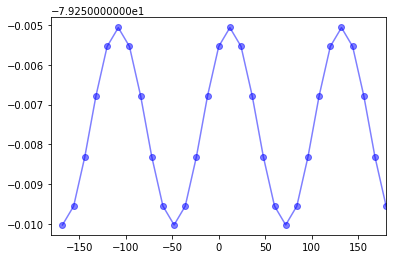

In [26]:
plt.plot(x_o, y_o, "bo", x_o,fitfunc(p1,x_o),"b-",alpha=0.5)
plt.xlim(-180,180)
plt.show()

## Энергия при больших длинах связи CC

Дополнительно посмотрим на то, что происходит с энергией молекулы при больших значениях длины ковалентной связи.

In [4]:
g_f = '''
C
C 1 {0}
H 1 1.08439 2 111.200
H 1 1.08439 2 111.200 3 120
H 1 1.08439 2 111.200 3 -120
H 2 1.08439 1 111.200 3 180
H 2 1.08439 1 111.200 6 120
H 2 1.08439 1 111.200 6 -120
'''

dist = 1
dists = []
energies_d = []
for i in range(30):
    g = g_f.format(dist)
    energy = run_psi4(g)
    dist = round(dist + 0.1,2)
    dists.append(dist)
    energies_d.append(energy)

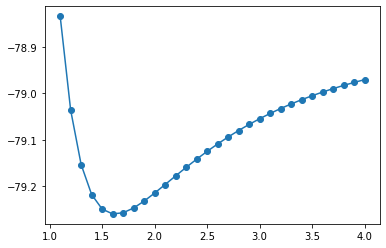

In [5]:
dists = np.array(dists)
energies_d = np.array(energies_d)
plt.plot(dists,energies_d,marker='o')

Мы видим, что при больших отклоениях от равновесного положения зависимость перестаёт быть параболической и слева начинает расти очень резко, а справа приближается к пределу - энергии диссоциации. Такая форма потенциала описывается с помощью потенциала Морзе. Подберём параметры, чтобы аппроксимировать найденную зависимость. Для этого сначала запишем, какой вид имеет функция, которую мы собрались использовать:

<img src="./e845fa6389629255129fa3a5a0fabf48aa85b17a.svg"/>

In [11]:
# fake x array , replace with real one
x_o=dists
# fake y array, replace with energies
y_o=energies_d

#function is  f(x)=D*(1-e**(-a*(x-x0)))**2+E0
fitfunc = lambda p, x: p[0]*(1-e**(-p[1]*(x-p[2])))**2+p[3] # Target function
errfunc = lambda p, x, y: fitfunc(p, x) - y # Error function

p0 = [1,1, 1,1] # Initial guess for the parameters
p1, success = optimize.leastsq(errfunc, p0[:], args=(x_o, y_o))
print("Optimized params:", p1)

Optimized params: [  0.30617389   1.39218556   1.65608808 -79.26633775]


Итого мы получили 4 параметра: первый означает глубину потенциальной ямы, что соответствует энергии диссоциации молекулы; второй связан с шириной потенциальной ямы; третий равен равновесному расстоянию между атомами (он немного отличается от полученного ранее за счёт того, что сейчас мы делали более грубые вычисления - с большим шагом); ну и последний параметр как всегда нужен для установления уровня энергии, относительно которого ведётся отсчёт.

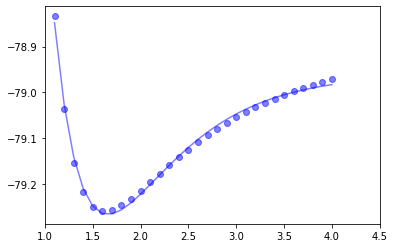

In [18]:
plt.plot(x_o, y_o, "bo", x_o,fitfunc(p1,x_o),"b-",alpha=0.5)
plt.xlim(1,4.5)
plt.show()

Удивительным образом потенциал Морзе идеально подошёл для описания нашей зависимости. Хоть в учебник вставляй.

##  Зависимость энергии от длины ковалентной связи CH

In [8]:
g_f = '''
C
C 1 1.52986
H 1 {0} 2 111.200
H 1 {0} 2 111.200 3 120
H 1 {0} 2 111.200 3 -120
H 2 {0} 1 111.200 3 180
H 2 {0} 1 111.200 6 120
H 2 {0} 1 111.200 6 -120
'''

dist: 0.9    energy: -79.0682868680291
dist: 0.92    energy: -79.11386229065143
dist: 0.94    energy: -79.15181812671827
dist: 0.96    energy: -79.18292509948319
dist: 0.98    energy: -79.20787466895122
dist: 1.0    energy: -79.22728795503296
dist: 1.02    energy: -79.24172352101903
dist: 1.04    energy: -79.25168418550847
dist: 1.06    energy: -79.25762300809653
dist: 1.08    energy: -79.25994857188763
dist: 1.1    energy: -79.25902966354201
dist: 1.12    energy: -79.25519943439296
dist: 1.14    energy: -79.24875910890992
dist: 1.16    energy: -79.23998129406067
dist: 1.18    energy: -79.22911293441621
dist: 1.2    energy: -79.21637794900091
dist: 1.22    energy: -79.20197958247597
dist: 1.24    energy: -79.18610249749321
dist: 1.26    energy: -79.16891463468001
dist: 1.28    energy: -79.15056886322904


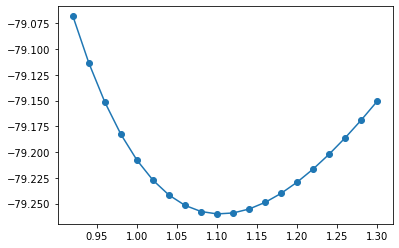

In [10]:
dist = 0.9
dists = []
energies_d = []
for i in range(20):
    g = g_f.format(dist)
    energy = run_psi4(g)
    print('dist: '+str(dist)+'    energy: '+str(energy))
    dist = round(dist + 0.02,2)
    dists.append(dist)
    energies_d.append(energy)
    
dists = np.array(dists)
energies_d = np.array(energies_d)
plt.plot(dists,energies_d,marker='o')

In [11]:
# fake x array , replace with real one
x_o=dists
# fake y array, replace with energies
y_o=energies_d

#function is  f(x)=k(b-x)^2 + a
fitfunc = lambda p, x: p[0]*pow(p[1]-x,2) + p[2] # Target function
errfunc = lambda p, x, y: fitfunc(p, x) - y # Error function

p0 = [1,1, -79] # Initial guess for the parameters
p1, success = optimize.leastsq(errfunc, p0[:], args=(x_o, y_o))
print("Optimized params:", p1)

Optimized params: [  4.14646247   1.12512373 -79.26204937]


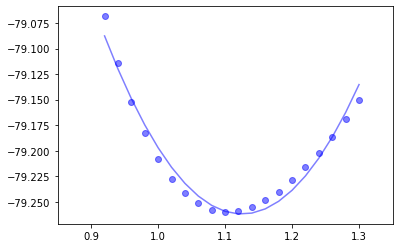

In [13]:
#Plot it
plt.plot(x_o, y_o, "bo", x_o,fitfunc(p1,x_o),"b-",alpha=0.5)
plt.xlim(0.85,1.35)
plt.show()